In [1]:
import sys
dasit_directory = "/Users/rricker/GitLab/projects/DriftAware-SIAlt"
sys.path.append(dasit_directory)

from visualization import visualization_tools
from data_handler.sea_ice_concentration_products import SeaIceConcentrationProducts
import xarray as xr
import matplotlib.pyplot as plt
import glob
import re
import os
import datetime
import yaml
import numpy as np
import cartopy.crs as ccrs
import cartopy
import sys
import matplotlib
import seaborn as sns
from pyproj.crs import CRS
from matplotlib.colors import ListedColormap
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import seaborn as sns

with open('/Users/rricker/GitLab/projects/DriftAware-SIAlt/config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [9]:
with open('/Users/rricker/GitLab/projects/DriftAware-SIAlt/config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
sensor = config["options"]["sensor"]
target_var = config["options"]["target_variable"]
stk_opt = config['options']['proc_step_options']['stacking']
multiproc = stk_opt['multiproc']
parcel_grid_opt = stk_opt['parcel_grid']
growth_grid_opt = stk_opt['growth_estimation']['growth_grid']

In [27]:
stk_opt['t_start'] = stk_opt['t_start'].replace(year=2007)

In [28]:
(datetime.datetime(stk_opt['t_start'].year + 1, 5, 1, 0, 0) - stk_opt['t_start']).days

213

In [29]:
stk_opt['t_start']

datetime.datetime(2007, 10, 1, 0, 0)

In [30]:
datetime.datetime(stk_opt['t_start'].year + 1, 5, 1, 0, 0)

datetime.datetime(2008, 5, 1, 0, 0)

In [2]:
outdir='/Volumes/data2/projects/DriftAware-SIAlt/product/envisat/geojson/'


In [10]:
os.path.normpath(os.path.join(outdir, '..'))+'/'

'/Volumes/data2/projects/DriftAware-SIAlt/product/envisat/geojson/'

In [3]:
os.path.normpath(os.path.join(outdir, '..'))+'/'

'/Volumes/data2/projects/DriftAware-SIAlt/product/envisat/'

In [356]:
def generate_t(k):
    start, end, step = (0, k + 1, 1) if k >= 0 else (0, k - 1, -1)
    tmp = list(range(start, end, step))
    return tmp[::-1]

def create_diverging_colormap():
    colors = [
        (0.4, 0, 0.4), 
        (1.00, 1.00, 1.00),  
        (1.00, 0.4, 0.05)]
    cmap = LinearSegmentedColormap.from_list('PuOr', colors, N=256)
    return cmap

def visu_xarray(x, y, z, figsize, vmin, vmax, n_level, cmap, time_string, label, outfile, iceconc=None):
    fontsize=14
    crs = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0, false_easting=0.0,
                                         false_northing=0.0)
    fig = plt.figure(figsize=figsize)

    xc, yc = np.meshgrid(x, y)

    bounds = list(np.linspace(vmin, vmax, num=n_level))
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend='neither')
    ax = plt.subplot(projection=crs)

    ax.set_extent([-3800000, 3000000, -3000000, 3800000], crs=crs)
    if iceconc:
        if len(iceconc) > 0:
            iceconc["ice_conc"][iceconc["ice_conc"] < 15.0] = np.nan
            iceconc["ice_conc"][iceconc["ice_conc"] >= 15.0] = 1.0
            ax.pcolormesh(xc, -yc, iceconc["ice_conc"], cmap=ListedColormap([(1,1,1)]))

    im = ax.pcolormesh(xc, yc, z, cmap=cmap, norm=norm)
    gl = ax.gridlines(draw_labels=False, linewidth=1.0, color='black', linestyle='--', ylocs=[88])
    gl.xlines = False
    ax.add_feature(cartopy.feature.OCEAN, facecolor=(0.86, 0.87, 0.9))
    ax.add_feature(cartopy.feature.LAND, facecolor=(0.73, 0.74, 0.75), zorder=2)    
    ax.coastlines(linewidth=0.2, color='black', zorder=3)
    ax.axis("off")
    cax = ax.inset_axes([0.85, 0.39, 0.025, 0.42], transform=ax.transAxes)
    cb = plt.colorbar(im, ax=ax, shrink=0.7, orientation='vertical', cax=cax)
    plt.annotate(time_string[6:8] + '.' + time_string[4:6] + '.' + time_string[0:4],
                 xy=(0.02, 0.965), fontsize=fontsize, xycoords='axes fraction', color='black')

    cb.set_label(label=label, size=fontsize, color='black')
    cb.ax.tick_params(labelsize=11, color='black', labelcolor='black')
    cb.outline.set_linewidth(0)
    plt.close(fig)
    fig.savefig(outfile, bbox_inches='tight', pad_inches=0, dpi=400)

In [357]:
target_var = "sea_ice_thickness_growth_unc"

sensor = config['options']['sensor']
hem = config["options"]["hemisphere"]
out_epsg = config["options"]["out_epsg"]
visu_opt = config['options']['proc_step_options']['visualization']
make_gif = visu_opt['make_gif']
config['dir'][sensor]['netcdf'] = "/Volumes/data2/projects/DriftAware-SIAlt/product/cryosat2/netcdf/sea_ice_thickness-nh-16fr-epsg6931_250-2023-12-11_12-52-09"
file_list = sorted(glob.glob(config['dir'][sensor]['netcdf'] + "/" + '*.nc'))

out_dir = "/Users/rricker/Documents/projects/ESA_CCI+Phase2_option/deliverables/D3-ATBD/figures/"

sic_product = SeaIceConcentrationProducts(hem=hem, product_id=config['options']['ice_conc_product'],
                                          out_epsg=out_epsg)
sic_product.get_file_list(config['dir']['auxiliary']['ice_conc'][config['options']['ice_conc_product']])
sic_product.get_file_dates()

file_list_flt = [file_list[45],file_list[166]]

for file in file_list_flt:
    time_str = re.search('nh-(.+?)-(.*).nc', os.path.basename(file)).group(1)
    dt1d = datetime.timedelta(days=1)
    t0 = datetime.datetime.strptime(time_str, '%Y%m%d')
    t1 = t0 + dt1d

    sic_product.target_files = sic_product.get_target_files(t0, t1)
    ice_conc = sic_product.get_ice_concentration(sic_product.target_files)

    data = xr.open_dataset(file, decode_times=False)

    if target_var in ['sea_ice_thickness', 'sea_ice_thickness_corrected']:
        vmin, vmax, n_level = 0, 5, 11
        cmap = sns.color_palette("cool", as_cmap=True)
        scaling = 1.0
        label = 'Sea ice thickness (m)'

    elif target_var in ['sea_ice_thickness_unc', 'sea_ice_thickness_total_unc', 'sea_ice_thickness_drift_unc', 'sea_ice_thickness_growth_unc']:
        vmin, vmax, n_level = 0, 1, 11
        cmap = plt.cm.cool
        scaling = 1.0
        label = 'Sea ice thickness uncertainty (m)'

    elif target_var == "dist_acquisition":
        vmin, vmax, n_level = 0, 200, 21
        cmap = plt.cm.cool
        scaling = 1.0
        label = 'Distance to data aquisition (km)'

    elif target_var == "time_offset_acquisition":
        vmin, vmax, n_level = -15, 15, 31
        cmap = create_diverging_colormap()
        scaling = 1.0
        label = 'Data aquisition time offset (days)'

    elif target_var in ['sea_ice_thickness_growth', 'sea_ice_thickness_growth_interpolated']:
        vmin, vmax, n_level = -5, 5, 21
        cmap = create_diverging_colormap()
        scaling = 100.0
        label = 'Thickness growth (cm/day)'

    if not os.path.exists(out_dir + target_var):
        try:
            os.mkdir(out_dir + target_var)
        except OSError as error:
            print(error)

    outfile = out_dir + target_var + os.sep + re.split('.nc', os.path.basename(file))[0] + '_' + target_var + '.png'
    
    visu_xarray(data.xc, data.yc, data[target_var][0] * scaling,
            (8, 8),
            vmin, vmax, n_level,
            cmap,
            time_str,
            label,
            outfile,
            iceconc=ice_conc)

In [358]:
bounds = [-600000, 800000, -1500000, -200000]
file = "/Volumes/data2/projects/DriftAware-SIAlt/product/cryosat2/geojson/sea_ice_thickness-nh-16fr-epsg6931_141-2023-12-05_17-58-30/sea_ice_thickness-cryosat2-nh-20200315-v100-epsg6931_141.geojson"
data = gpd.read_file(file)
data = data[abs(data['dt_days'])>=15].reset_index(drop=True)

In [359]:
start_location = data["geometry"].apply(lambda g: g.geoms[0])
end_location = data["geometry"].apply(lambda g: g.geoms[-1])
gdf = data.iloc[start_location.cx[bounds[0]:bounds[1], bounds[2]:bounds[3]].index].reset_index(drop=True)

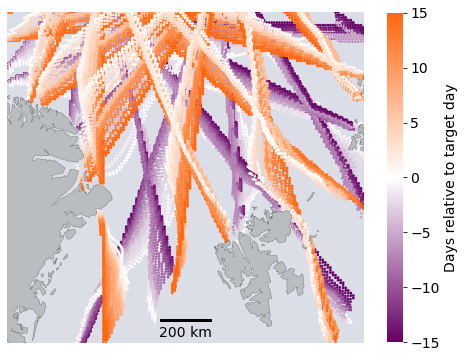

In [381]:
out_dir = "/Users/rricker/Documents/projects/ESA_CCI+Phase2_option/deliverables/D3-ATBD/figures/"
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0, false_easting=0.0,
                                     false_northing=0.0)
cmap = create_diverging_colormap()
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection=crs)
ax.set_extent(bounds, crs=crs)
ax.add_feature(cartopy.feature.OCEAN, facecolor=(0.86, 0.87, 0.9))
ax.add_feature(cartopy.feature.LAND, facecolor=(0.73, 0.74, 0.75),zorder=2)    
ax.coastlines(linewidth=0.2, color='black',zorder=3)
ax.axis("off")
for i in range(0,len(gdf)):
    t = generate_t(gdf["dt_days"][i])
    x = [point.x for point in gdf["geometry"][i].geoms]
    y = [point.y for point in gdf["geometry"][i].geoms]
    im = ax.scatter(x,y,c=t, marker='o', cmap=cmap, s=3,vmin=-15, vmax=15,zorder=1)

cb = plt.colorbar(im, ax=ax, shrink=0.758, orientation='vertical')
cb.set_label(label='Days relative to target day', size=14, color='black')
cb.ax.tick_params(labelsize=14, color='black', labelcolor='black')
cb.outline.set_linewidth(0)

fontprops = fm.FontProperties(size=14)
scalebar = AnchoredSizeBar(ax.transData,
                           200000, '200 km','lower center', 
                           pad=0.15,
                           sep=5,
                           color='black',
                           frameon=False,
                           size_vertical=6000,
                           fontproperties=fontprops)
ax.add_artist(scalebar)
fig.savefig(out_dir+'Fram_Strait_Trajectories', bbox_inches='tight', pad_inches=0, dpi=400)

In [353]:
def generate_t(k):
    start, end, step = (0, k + 1, 1) if k >= 0 else (0, k - 1, -1)
    tmp = list(range(start, end, step))
    return tmp[::-1]

t = generate_t(-15)

In [383]:
np.sqrt(2*10**2)

14.142135623730951

In [384]:
2*10**2

200

In [382]:
np.sqrt( 0.04)

0.2

In [385]:
config

{'version': 'v100',
 'dir': {'cryosat2': {'level2': {'sea_ice_freeboard': '/Volumes/data2/projects/DriftAware-SIAlt/data/cryosat2/l2p_cci/',
    'sea_ice_thickness': '/Volumes/data2/projects/DriftAware-SIAlt/data/cryosat2/l2p_cci/'},
   'geojson': '/Volumes/data2/projects/DriftAware-SIAlt/product/cryosat2/geojson/',
   'netcdf': '/Volumes/data2/projects/DriftAware-SIAlt/product/cryosat2/netcdf/',
   'visu': '/Volumes/data2/projects/DriftAware-SIAlt/analysis/cryosat2/plots/'},
  'envisat': {'level2': {'sea_ice_freeboard': '/Volumes/data2/projects/DriftAware-SIAlt/data/envisat/l2p_cci/',
    'sea_ice_thickness': '/Volumes/data2/projects/DriftAware-SIAlt/data/envisat/l2p_cci/'},
   'geojson': '/Volumes/data2/projects/DriftAware-SIAlt/product/envisat/geojson/',
   'netcdf': '/Volumes/data2/projects/DriftAware-SIAlt/product/envisat/netcdf/',
   'visu': '/Volumes/data2/projects/DriftAware-SIAlt/analysis/envisat/plots/'},
  'icesat2': {'level2': {'total_freeboard': '/Volumes/data2/projects/Dr

In [394]:
import scipy

numpy_version = np.__version__
print(f"NumPy version: {numpy_version}")

NumPy version: 1.22.3


In [388]:
from scipy import interpolate
fsm = interpolate.interp1d(np.array([40.0, 90.0]), np.array([80, 10]))

In [389]:
fsm

In [391]:
np.array([80, 10])

array([80, 10])

In [397]:
file = "/Volumes/data2/projects/DriftAware-SIAlt/product/cryosat2/geojson/sea_ice_thickness-nh-16fr-epsg6931_141-2023-12-05_17-58-30/sea_ice_thickness-cryosat2-nh-20200315-v100-epsg6931_141.geojson"
data = gpd.read_file(file)

In [403]:
data.keys()

Index(['sea_ice_thickness', 'sea_ice_thickness_std', 'sea_ice_thickness_hist',
       'sea_ice_thickness_unc', 'snow_depth', 't0', 'dt_days', 'ice_conc',
       'sea_ice_thickness_drift_unc', 'divergence', 'shear',
       'sea_ice_thickness_corr', 'sea_ice_thickness_growth_unc',
       'growth_interpolated', 'growth', 'geometry'],
      dtype='object')

In [404]:
print(data.dtypes)

sea_ice_thickness                float64
sea_ice_thickness_std            float64
sea_ice_thickness_hist            object
sea_ice_thickness_unc            float64
snow_depth                       float64
t0                               float64
dt_days                            int64
ice_conc                         float64
sea_ice_thickness_drift_unc      float64
divergence                        object
shear                             object
sea_ice_thickness_corr           float64
sea_ice_thickness_growth_unc     float64
growth_interpolated              float64
growth                           float64
geometry                        geometry
dtype: object


In [410]:
data['sea_ice_thickness_hist'][0]

'0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'

In [416]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 217561 entries, 0 to 217560
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   sea_ice_thickness             217561 non-null  float64 
 1   sea_ice_thickness_std         217561 non-null  float64 
 2   sea_ice_thickness_hist        217561 non-null  object  
 3   sea_ice_thickness_unc         217561 non-null  float64 
 4   snow_depth                    217561 non-null  float64 
 5   t0                            217561 non-null  float64 
 6   dt_days                       217561 non-null  int64   
 7   ice_conc                      217561 non-null  float64 
 8   sea_ice_thickness_drift_unc   217561 non-null  float64 
 9   divergence                    217561 non-null  object  
 10  shear                         217561 non-null  object  
 11  sea_ice_thickness_corr        217561 non-null  float64 
 12  sea_ice_thickness_grow

In [417]:
data['ice_conc']

0         0.265268
1         0.542425
2         0.646432
3         0.645939
4         0.630258
            ...   
217556    0.888593
217557    0.863650
217558    0.847960
217559    0.832389
217560    0.804708
Name: ice_conc, Length: 217561, dtype: float64

In [58]:
sensor = config["options"]["sensor"]
stk_opt = config['options']['proc_step_options']['stacking']
multiproc = stk_opt['multiproc']
parcel_grid_opt = stk_opt['parcel_grid']
growth_grid_opt = stk_opt['growth_estimation']['growth_grid']

if stk_opt['t_length'] == 'season':
    stk_opt['t_length'] = (datetime.datetime(stk_opt['t_start'].year + 1, 5, 1, 0, 0) - stk_opt['t_start']).days


In [63]:
target_var = config["options"]["target_variable"]
stk_opt = config['options']['proc_step_options']['stacking']
sensor = config["options"]["sensor"]
years = list(filter(lambda f: not f.startswith('.'), os.listdir(config['dir'][sensor]['level2'][target_var])))
years = [int(x) for x in years]
years = [y for y in years if y >= stk_opt['t_start'].year]

In [68]:
for yr in years:
    stk_opt['t_start'] = stk_opt['t_start'].replace(year=yr)
    print(stk_opt['t_start'])

2003-10-01 00:00:00
2004-10-01 00:00:00
2005-10-01 00:00:00
2006-10-01 00:00:00
2007-10-01 00:00:00
2008-10-01 00:00:00
2009-10-01 00:00:00
2010-10-01 00:00:00
2011-10-01 00:00:00
2012-10-01 00:00:00


In [71]:
with open('/Users/rricker/GitLab/projects/DriftAware-SIAlt/config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

sensor = config["options"]["sensor"]
target_var = config["options"]["target_variable"]
stk_opt = config['options']['proc_step_options']['stacking']
multiproc = stk_opt['multiproc']
parcel_grid_opt = stk_opt['parcel_grid']
growth_grid_opt = stk_opt['growth_estimation']['growth_grid']

#config['dir'][sensor]['geojson'] = create_out_dir(config, config['dir'][sensor]['geojson'], cell_width)

#logger.info('grid cell width of the stacking parcel grid: ' + str(cell_width) + ' m')

if stk_opt['t_length'] == 'all':
    years = list(filter(lambda f: not f.startswith('.'), os.listdir(config['dir'][sensor]['level2'][target_var])))
    years = [int(x) for x in years]
    years = [y for y in years if y >= stk_opt['t_start'].year]
else:
    years = [stk_opt['t_start'].year]

for yr in years:
    stk_opt['t_start'] = stk_opt['t_start'].replace(year=yr)

    if stk_opt['t_length'] in ['season', 'all']:
        stk_opt['t_length'] = (datetime.datetime(stk_opt['t_start'].year + 1, 5, 1, 0, 0) - stk_opt['t_start']).days
    
    print(stk_opt['t_length'])
    print(stk_opt['t_start'])

213
2003-10-01 00:00:00
